In [1]:
import numpy as np
import os
import shutil

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib

import sys
sys.path.append('../')
from utils import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 24, colors = 'banskt', dpi = 72)

In [2]:
normfile  = "/scratch/sbanerj/trans-eqtl/input/gtex/preprocess_gx/normalized/esom_normalized.txt"
covarfile = "/scratch/sbanerj/trans-eqtl/input/gtex/preprocess_gx/covariates/esom_nopeer_covariates_w_age.txt"

In [3]:
gx = list()
genes = list()
with open(normfile, 'r') as instream:
    header_orig = next(instream)
    for line in instream:
        linesplit = line.strip().split()
        thisgx = np.array([float(x) for x in linesplit[1:]])
        gx.append(thisgx)
        genes.append(linesplit[0])
gx = np.array(gx)
samples = header_orig.strip().split()[1:]

In [4]:
gx.shape

(25175, 241)

In [5]:
W = list()
covs = list()
with open(covarfile, 'r') as instream:
    header_cov = next(instream)
    for line in instream:
        linesplit = line.strip().split()
        thisW = np.array([float(x) for x in linesplit[1:]])
        W.append(thisW)
        covs.append(linesplit[0])
W = np.array(W)
cov_samples = header_cov.strip().split()
indices = np.array([cov_samples.index(x) for x in samples])
W = W[:, indices].copy()

In [6]:
W.shape

(8, 241)

In [5]:
# Normalize the covariates

Wnorm = (W - np.mean(W, axis = 1).reshape(-1, 1)) / np.std(W, axis = 1).reshape(-1, 1)

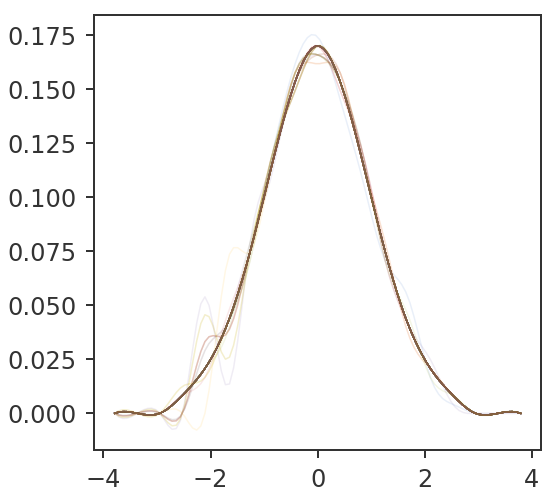

In [8]:
# Check gene expression normalization

fig = plt.figure()
ax1 = fig.add_subplot(111)

from scipy.interpolate import interp1d
bins = np.linspace(-4, 4, 20)
xbin = [(bins[i] + bins[i+1]) / 2 for i in range(bins.shape[0] - 1)] # centers of the bins
x = np.linspace(xbin[0], xbin[-1], 100)
for i in range(100):
    yhist, _ = np.histogram(gx[i, :], bins = bins)
    yfreq = yhist / len(samples)
    fy = interp1d(xbin, yfreq, kind = 'cubic')
    y = fy(x)
    ax1.plot(x, y, alpha = 0.1)
plt.show()

In [ ]:
# Visualize the data

# fig = plt.figure()
# ax1 = fig.add_subplot(111)
# ax1.scatter(Wnorm[7, :], gx[0, :], s = 2)
# plt.show()

In [ ]:
# Wnorm.shape

In [9]:
# Fit a multiple regression model

from sklearn import linear_model
linreg = linear_model.LinearRegression()
linreg.fit(Wnorm.T, gx.T)
gxcorr = gx - linreg.predict(Wnorm.T).T

In [10]:
# Normalize the corrected gene expression
def normalize_expr(Y):
    newY = (Y - np.mean(Y, axis = 1).reshape(-1, 1)) / np.std(Y, axis = 1).reshape(-1, 1)
    return newY

gxcorrnorm = normalize_expr(gxcorr)

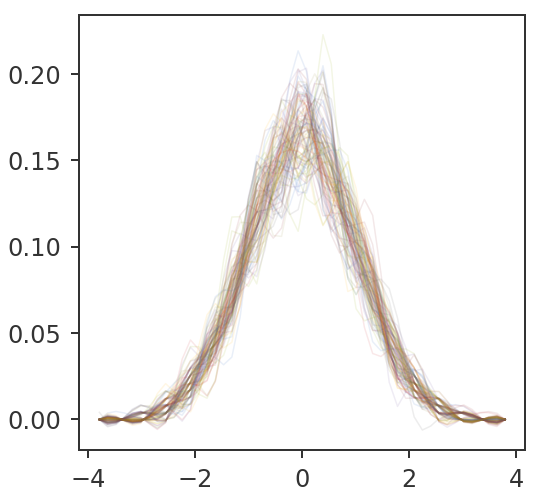

In [11]:
# Check new gene expression
fig = plt.figure()
ax1 = fig.add_subplot(111)

from scipy.interpolate import interp1d
bins = np.linspace(-4, 4, 20)
xbin = [(bins[i] + bins[i+1]) / 2 for i in range(bins.shape[0] - 1)] # centers of the bins
x = np.linspace(xbin[0], xbin[-1], 50)
for i in range(100):
    yhist, _ = np.histogram(gxcorrnorm[i, :], bins = bins)
    yfreq = yhist / len(samples)
    fy = interp1d(xbin, yfreq, kind = 'cubic')
    y = fy(x)
    ax1.plot(x, y, alpha = 0.1)
plt.show()

In [ ]:
# gxcorr[:5, :10]

In [39]:
from sklearn.decomposition import PCA

nComp = 1
pca = PCA()
pca.fit(gx.T)
# comp = pca.transform(gx.T)
# compstd = (comp - np.mean(comp, axis = 0)) / np.std(comp, axis=0)
# compsum = np.sum(compstd, axis = 1)
# compsum = np.sum(comp, axis = 1)
# gxpcacorr = gx - compsum.reshape(1, -1)
# gxpcacorrnorm = normalize_expr(gxpcacorr)

gxpca = np.dot(pca.transform(gx.T)[:, nComp:], pca.components_[nComp:,:]).T

In [40]:
gxpcanorm = normalize_expr(gxpca)

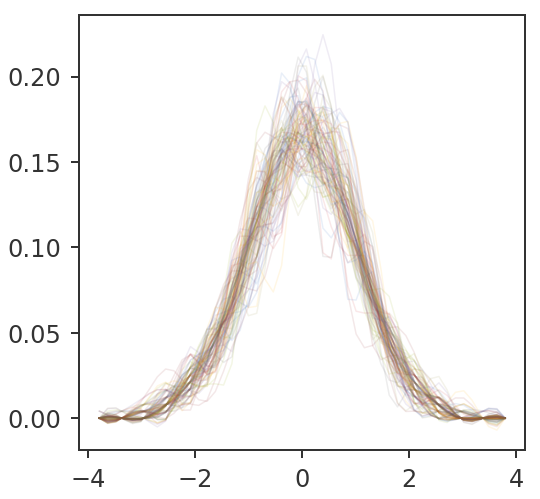

In [42]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

from scipy.interpolate import interp1d
bins = np.linspace(-4, 4, 20)
xbin = [(bins[i] + bins[i+1]) / 2 for i in range(bins.shape[0] - 1)] # centers of the bins
x = np.linspace(xbin[0], xbin[-1], 50)
for i in range(100):
    yhist, _ = np.histogram(gxpcanorm[i, :], bins = bins)
    yfreq = yhist / len(samples)
    fy = interp1d(xbin, yfreq, kind = 'cubic')
    y = fy(x)
    ax1.plot(x, y, alpha = 0.1)
plt.show()